# 📊 Round Robin Benchmark Analysis

This notebook loads the latest benchmark results from:

`src/ai/statistics/round_robin_results/*.csv`

and computes winrates, matchup charts, damage statistics, and NEAT-style metrics.

In [533]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Notebook working directory
CWD = Path().resolve()

# Walk upward until we find the project root (folder containing `src/`)
while CWD != CWD.root and not (CWD / "src").exists():
    CWD = CWD.parent

PROJECT_ROOT = CWD
print("Detected project root:", PROJECT_ROOT)

RESULTS_DIR = PROJECT_ROOT / "src/ai/statistics/round_robin_results"
print("Using results dir:", RESULTS_DIR)

csv_files = sorted(RESULTS_DIR.glob("round_robin_*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {RESULTS_DIR}")

latest_csv = csv_files[-1]
print("📄 Loading:", latest_csv)

df = pd.read_csv(latest_csv)
df.head()

Detected project root: D:\University\Szakdoga\Game
Using results dir: D:\University\Szakdoga\Game\src\ai\statistics\round_robin_results
📄 Loading: D:\University\Szakdoga\Game\src\ai\statistics\round_robin_results\round_robin_20251212_121637.csv


,agentA,agentB,winner,turns,avg_turn_time_A,avg_turn_time_B,initial_unit_count_team1,initial_unit_count_team2,alive1,alive2,max_hp_team1,max_hp_team2,hp1,hp2
0,MCTS_default,MCTS_fast,NaN,30,1.994487,0.798601,4,4,3,3,395,355,48,89
1,MCTS_default,MCTS_fast,NaN,30,2.029743,0.804627,5,4,3,1,575,425,240,21
2,MCTS_default,NEATAgent,2.0,28,1.780343,0.081306,4,3,0,1,365,270,0,64
3,MCTS_default,NEATAgent,NaN,30,2.026122,0.064285,5,4,2,2,570,370,102,89
4,MCTS_default,MCTS_deep,NaN,30,1.805326,3.622224,4,4,1,2,395,430,11,96


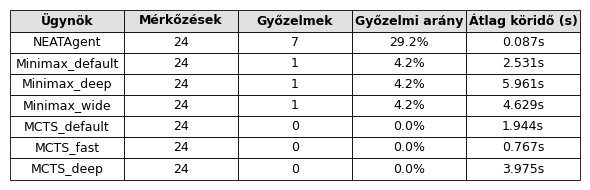

In [534]:
import matplotlib.pyplot as plt

# -----------------------------
# Compute summary
# -----------------------------
rows = []

agents = pd.unique(df[["agentA", "agentB"]].values.ravel())

for agent in agents:
    games = df[(df.agentA == agent) | (df.agentB == agent)]

    wins = (
        ((games.agentA == agent) & (games.winner == 1)).sum()
        + ((games.agentB == agent) & (games.winner == 2)).sum()
    )

    rows.append({
        "agent": agent,
        "games": len(games),
        "wins": wins,
        "winrate": wins / max(1, len(games)),
        "avg_turn_time": pd.concat([
            games.loc[games.agentA == agent, "avg_turn_time_A"],
            games.loc[games.agentB == agent, "avg_turn_time_B"],
        ]).mean(),
    })

summary = (
    pd.DataFrame(rows)
    .sort_values("winrate", ascending=False)
    .reset_index(drop=True)
)

# -----------------------------
# Build black & white table
# -----------------------------
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis("off")

columns = ["Ügynök", "Mérkőzések", "Győzelmek", "Győzelmi arány", "Átlag köridő (s)"]
cell_text = []

for _, row in summary.iterrows():
    cell_text.append([
        row["agent"],
        f"{row['games']}",
        f"{row['wins']}",
        f"{row['winrate']:.1%}",
        f"{row['avg_turn_time']:.3f}s",
    ])

table = ax.table(
    cellText=cell_text,
    colLabels=columns,
    loc="center",
    colLoc="center",
    cellLoc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(9)      # 🔽 smaller font
table.scale(1, 1.15)       # 🔽 tighter rows

# -----------------------------
# Styling (pure black & white)
# -----------------------------
for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor("black")
    cell.set_linewidth(0.6)

    if row == 0:
        cell.set_facecolor("#E0E0E0")
        cell.get_text().set_fontweight("bold")
        cell.get_text().set_color("black")
    else:
        cell.set_facecolor("white")
        cell.get_text().set_color("black")

plt.tight_layout()
plt.show()


Agent Timing Info

In [535]:
# Convert match rows into per-agent timing rows
rows = []

for _, r in df.iterrows():
    rows.append(
        {
            "agent": r["agentA"],
            "avg_turn_time": r["avg_turn_time_A"],
        }
    )
    rows.append(
        {
            "agent": r["agentB"],
            "avg_turn_time": r["avg_turn_time_B"],
        }
    )

df_agents = pd.DataFrame(rows)
df_agents

,agent,avg_turn_time
0,MCTS_default,1.994487
1,MCTS_fast,0.798601
2,MCTS_default,2.029743
3,MCTS_fast,0.804627
4,MCTS_default,1.780343
...,...,...
163,Minimax_default,1.985233
164,Minimax_wide,4.742871
165,Minimax_deep,5.573284
166,Minimax_wide,5.360139


In [536]:
agent_time = (
    df_agents.groupby("agent")["avg_turn_time"]
    .mean()
    .sort_values()
    .to_frame("mean_turn_time")
)

agent_time

,mean_turn_time
agent,
NEATAgent,0.087059
MCTS_fast,0.766924
MCTS_default,1.943939
Minimax_default,2.530690
MCTS_deep,3.974975
Minimax_wide,4.629116
Minimax_deep,5.960769


C:\Users\szaue\AppData\Local\Temp\ipykernel_10308\1049744420.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


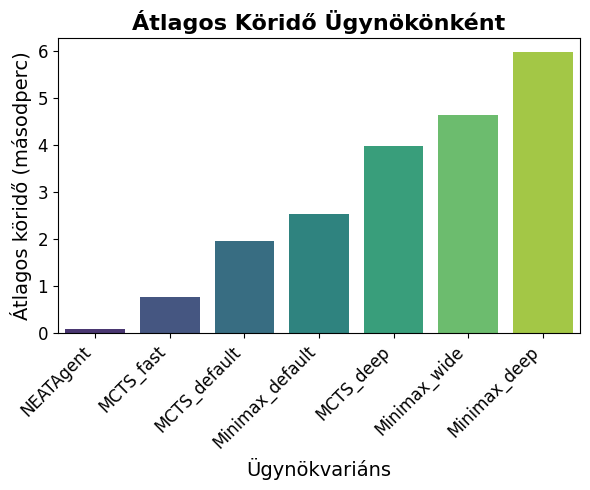

In [537]:
plt.figure(figsize=(6, 5))
sns.barplot(
    data=agent_time.reset_index(), x="agent", y="mean_turn_time", palette="viridis"
)

plt.title("Átlagos Köridő Ügynökönként", fontsize=16, fontweight="bold")
plt.ylabel("Átlagos köridő (másodperc)", fontsize=14)
plt.xlabel("Ügynökvariáns", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Does deeper minimax explode turn time?

In [538]:
minimax_rows = agent_time[agent_time.index.str.contains("Minimax")]

print("🧠 Minimax Compute Cost Comparison:")
minimax_rows

🧠 Minimax Compute Cost Comparison:


,mean_turn_time
agent,
Minimax_default,2.530690
Minimax_wide,4.629116
Minimax_deep,5.960769


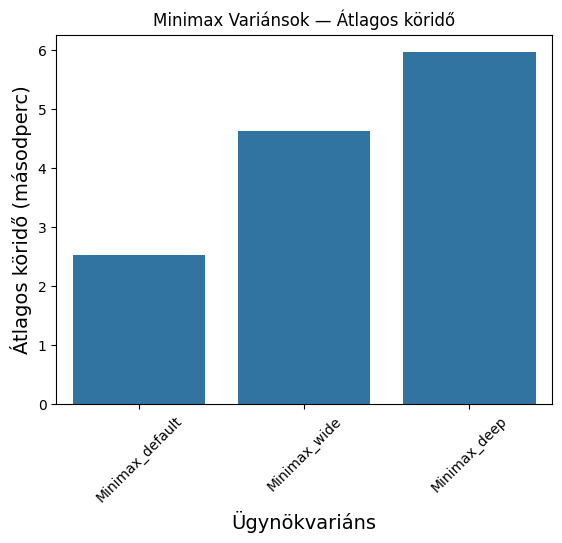

In [539]:
# Extract rollout_turns from preset name if you encode it there, or join
# from preset file
sns.barplot(x=minimax_rows.index, y=minimax_rows["mean_turn_time"])
plt.xticks(rotation=45)
plt.ylabel("Átlagos köridő (másodperc)", fontsize=14)
plt.xlabel("Ügynökvariáns", fontsize=14)
plt.title("Minimax Variánsok — Átlagos köridő")
plt.show()

Is MCTS rollout parameter affecting compute cost?

In [540]:
mcts_rows = agent_time[agent_time.index.str.contains("MCTS")]

print("🌲 MCTS Compute Cost Comparison:")
mcts_rows

🌲 MCTS Compute Cost Comparison:


,mean_turn_time
agent,
MCTS_fast,0.766924
MCTS_default,1.943939
MCTS_deep,3.974975


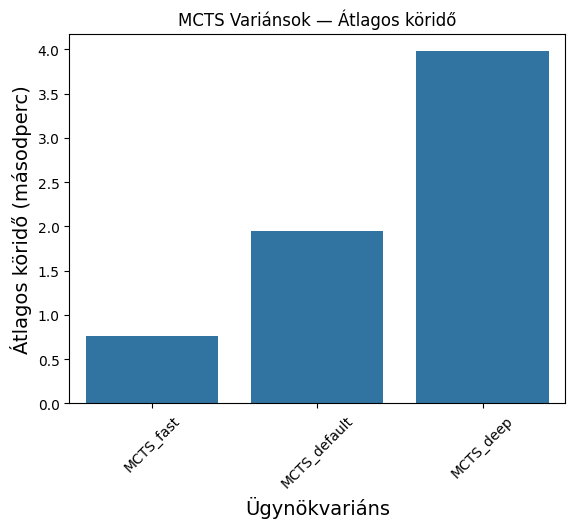

In [541]:
# Extract rollout_turns from preset name if you encode it there, or join
# from preset file
sns.barplot(x=mcts_rows.index, y=mcts_rows["mean_turn_time"])
plt.xticks(rotation=45)
plt.ylabel("Átlagos köridő (másodperc)", fontsize=14)
plt.xlabel("Ügynökvariáns", fontsize=14)
plt.title("MCTS Variánsok — Átlagos köridő")
plt.show()

## 🧮 Winrate Summary

In [542]:
agents = sorted(set(df["agentA"]) | set(df["agentB"]))

# Collect stats
win_stats = {a: {"wins": 0, "games": 0, "time_sum": 0.0} for a in agents}

for _, row in df.iterrows():
    A, B, winner = row["agentA"], row["agentB"], row["winner"]

    # --- Agent A ---
    win_stats[A]["games"] += 1
    win_stats[A]["time_sum"] += row["avg_turn_time_A"]
    if winner == 1:
        win_stats[A]["wins"] += 1

    # --- Agent B ---
    win_stats[B]["games"] += 1
    win_stats[B]["time_sum"] += row["avg_turn_time_B"]
    if winner == 2:
        win_stats[B]["wins"] += 1

# Build summary table
summary = pd.DataFrame(
    [
        {
            "agent": agent,
            "winrate": win_stats[agent]["wins"] / win_stats[agent]["games"],
            "avg_turn_time": win_stats[agent]["time_sum"] / win_stats[agent]["games"],
        }
        for agent in agents
    ]
).set_index("agent")

summary

,winrate,avg_turn_time
agent,,
MCTS_deep,0.000000,3.974975
MCTS_default,0.000000,1.943939
MCTS_fast,0.000000,0.766924
Minimax_deep,0.041667,5.960769
Minimax_default,0.041667,2.530690
Minimax_wide,0.041667,4.629116
NEATAgent,0.291667,0.087059


## 🔥 Head-to-Head Winrate Matrix

In [543]:
matrix = pd.DataFrame(0.0, index=agents, columns=agents)

for _, row in df.iterrows():
    A, B, winner = row["agentA"], row["agentB"], row["winner"]
    if winner == 1:
        matrix.loc[A, B] += 1
    elif winner == 2:
        matrix.loc[B, A] += 1

games_matrix = df.groupby(["agentA", "agentB"]).size().unstack(fill_value=0)

winrate_matrix = matrix.div(games_matrix + games_matrix.T, fill_value=0)
winrate_matrix

,MCTS_deep,MCTS_default,MCTS_fast,Minimax_deep,Minimax_default,Minimax_wide,NEATAgent
MCTS_deep,NaN,0.00,0.00,0.00,0.00,0.0,0.0
MCTS_default,0.0,NaN,0.00,0.00,0.00,0.0,0.0
MCTS_fast,0.0,0.00,NaN,0.00,0.00,0.0,0.0
Minimax_deep,0.0,0.00,0.25,NaN,0.00,0.0,0.0
Minimax_default,0.0,0.25,0.00,0.00,NaN,0.0,0.0
Minimax_wide,0.0,0.25,0.00,0.00,0.00,NaN,0.0
NEATAgent,0.5,0.50,0.25,0.25,0.25,0.0,NaN


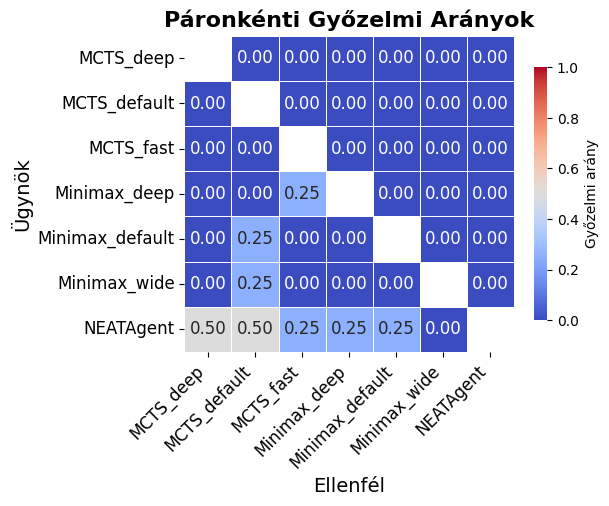

In [544]:
plt.figure(figsize=(6,5))  # smaller figure → smaller grid cells

ax = sns.heatmap(
    winrate_matrix,
    annot=True,
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    fmt=".2f",
    linewidths=0.7,
    annot_kws={"size": 12}, 
    cbar_kws={"label": "Győzelmi arány", "shrink": 0.8},
)

# Axis labels
ax.set_xlabel("Ellenfél", fontsize=14)
ax.set_ylabel("Ügynök", fontsize=14)

# Title
ax.set_title("Páronkénti Győzelmi Arányok", fontsize=16, fontweight="bold")

# Tick labels
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout(pad=0.5)  # reduce padding → grid fills more space
plt.show()

## Turn Time Winrate Correlation

C:\Users\szaue\AppData\Local\Temp\ipykernel_10308\2825518273.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


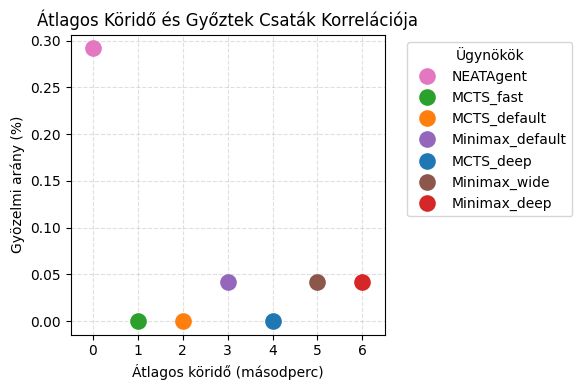

In [545]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
import matplotlib.cm as cm

plt.figure(figsize=(6, 4))

# Create a color palette for each agent
agents = summary.reset_index()["agent"].unique()
cmap = cm.get_cmap("tab10")
palette = {agent: cmap(i) for i, agent in enumerate(agents)}

sns.stripplot(
    data=summary.reset_index(),
    x="avg_turn_time",
    y="winrate",
    hue="agent",
    palette=palette,
    jitter=0.25,
    size=12,
    legend=True,
)

plt.title("Átlagos Köridő és Győztek Csaták Korrelációja")
plt.xlabel("Átlagos köridő (másodperc)")
plt.ylabel("Gyözelmi arány (%)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Ügynökök", bbox_to_anchor=(1.05, 1), loc="upper left")

# Round up x-axis numbers
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(np.ceil(x))}'))

plt.tight_layout()
plt.show()

## ⛑️ Survival Ratio

In [546]:
# Compute alive ratio per agent from stats
alive_rows = []

for _, r in df.iterrows():
    alive_rows.append(
        {
            "agent": r["agentA"],
            "alive_ratio": r["alive1"] / max(1, r["initial_unit_count_team1"]),
        }
    )
    alive_rows.append(
        {
            "agent": r["agentB"],
            "alive_ratio": r["alive2"] / max(1, r["initial_unit_count_team2"]),
        }
    )

df_alive = pd.DataFrame(alive_rows)
agent_alive = df_alive.groupby("agent")["alive_ratio"].mean().to_frame("alive_ratio")

agent_alive

,alive_ratio
agent,
MCTS_deep,0.448611
MCTS_default,0.465278
MCTS_fast,0.469444
Minimax_deep,0.572917
Minimax_default,0.563889
Minimax_wide,0.575000
NEATAgent,0.636806


C:\Users\szaue\AppData\Local\Temp\ipykernel_10308\1804752020.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


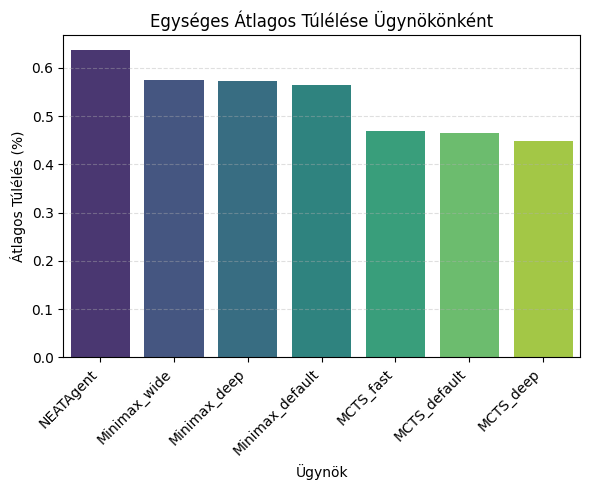

In [547]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))

# Sort by alive_ratio for better visualization
agent_alive_sorted = agent_alive.sort_values("alive_ratio", ascending=False)

sns.barplot(
    data=agent_alive_sorted.reset_index(),
    x="agent",
    y="alive_ratio",
    palette="viridis",
)

plt.title("Egységes Átlagos Túlélése Ügynökönként")
plt.xlabel("Ügynök")
plt.ylabel("Átlagos Túlélés (%)")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()